##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# MoveNet: Ultra fast and accurate pose detection model.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/movenet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

**[MoveNet](https://t.co/QpfnVL0YYI?amp=1)** is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.


<img src="https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/combined_squat_dance.gif" alt="drawing"/>

*Images downloaded from Pexels (https://www.pexels.com/)

This Colab walks you through the details of how to load MoveNet, and run inference on the input image and video below.

Note: check out the [live demo](https://storage.googleapis.com/tfjs-models/demos/pose-detection/index.html?model=movenet) for how the model works!

# Human Pose Estimation with MoveNet

## Visualization libraries & Imports

In [2]:
# !pip install -q imageio
# !pip install -q opencv-python
# !pip install -q git+https://github.com/tensorflow/docs

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display
import pandas as pd

In [4]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF hub

In [5]:
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

## Single Image Example

This session demonstrates the minumum working example of running the model on a **single image** to predict the 17 human keypoints.

### Load Input Image

In [6]:
# !curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent

In [68]:
# Load the input image.
image_path = r'D:\Pemrograman\Python\Project\Hidup-Sehat-Machine-Learning\PoseEstimation\images\stress_relief\Upward-Salute_Andrew-Clark.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)[:,:,:3]

InvalidArgumentError: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]

### Run Inference

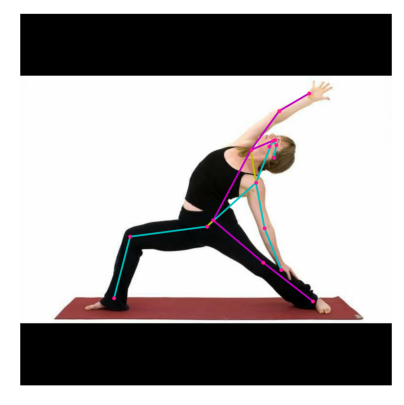

In [67]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [12]:
# 17 keypoints in the model output
kp_descriptions = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

### Extraction

In [ ]:
[
  {
    "id": "string",
    "cardColor": 4,
    "type": "Yoga",
    "category": "Ketenangan",
    "difficulty": "Pemula",
    "imgUrl": "string",
    "caloriesBurned": 100,
    "movementCount": 3,
    "movementList": [
      {
        "movementName": "Berdiri Membungkuk ke Depan",
        "movementDesc": "Lipatan depan yang sederhana namun efektif yang mendorong Anda menuju fleksibilitas yang lebih besar di sepanjang tubuh belakang Anda",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81qJHhyAnYnBA2rMdphKTLB3N7S-jLEOyi6DpNOzUPG2N6e2jaQvmR3ehMrfC6UakoqOp8AsWUw1Acdm9KTuz5b2KMTG=s1600",
      }, 
      {
        "movementName": "Berdiri Setengah Menekuk Ke Depan",
        "movementDesc": "Pose setengah membungkuk ke depan memperkuat punggung, memanjangkan tulang belakang, dan meningkatkan fleksibilitas pinggul dan paha belakang Anda. Pose yoga ini juga meregangkan dada, menguatkan kaki, dan merangsang perut",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81qkhB1w5ns1PLvY_xx8Peh1YTG-rWMhgwm4Fp5ttBzTmUHIm4ftCV8MJ0hEbz2bHfT_El9aY1gNKmVRNPvXd1_XyHDR=s1600",
      },
      {
        "movementName": "Pose Sudut Berbaring",
        "movementDesc": "Pose Sudut Berbaring meregangkan selangkangan, paha bagian dalam, dan pinggul serta membantu meredakan gejala stres, kecemasan, dan depresi.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81p7l2v--UJPnvk9ObU0645a48YjEiHuDpcb0GI-pZnhL6l0GD6q8i_ysQPOVLwWhfy5H-d2Vih0fjXVLSG6rIF98zzPLg=s1600",
      }
    ]
  },
  {
    "id": "string",
    "cardColor": 3,
    "type": "Yoga",
    "category": "Kecemasan",
    "difficulty": "Pemula",
    "imgUrl": "string",
    "caloriesBurned": 100,
    "movementCount": 5,
    "movementList": [
      {
        "movementName": "Pose Kucing",
        "movementDesc": "Mengurangi sakit punggung · Menenangkan pikiran · Memperbaiki postur · Meningkatkan koordinasi",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81qbYjqKQ7Feg0JrPa4Tema6Knu_0GJTfk4ewVPaRzt1W4uHNtL_WB-B8ENHjCqQ_Hhhv0b-j4v0WcCdn2sP1aIUKJLIPw=s1600",
      }, 
      {
        "movementName": "Kaki Naik Pose Dinding",
        "movementDesc": "selain mengurangi stres dan cemas, pose legs up the wall juga memiliki manfaat lainnya yaitu mengurangi nyeri lutut, meredakan leher yang tegang, meringankan kaki yang lemah, meredakan kram kaki, dan mengurangi sakit punggung",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81r1LlsBh6ywT0wKQGMqcUGpJt5u-rrjztyX90d5_r-dsRhpZDeomoxG1t8ZzrAnB_NzADIn8vqSZ9G0JIeNC4oSvqFq=s1600",
      },
      {
        "movementName": "Salam Ke atas",
        "movementDesc": "Salam Ke atas meregangkan sisi tubuh, tulang belakang, bahu, ketiak, dan perut. Ini mengencangkan paha, meningkatkan pencernaan, dan membantu menghilangkan kecemasan dan kelelahan. Ini juga membantu menciptakan ruang di dada dan paru-paru, yang merupakan terapi untuk asma dan kemacetan.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81o0HetmkeOCPp_vfEoIA00xoFT-3HEK0VCE5TXe3KqwWXvwarColY1DT6XZJVVdFBZimZnz5T24mtyeBw8fW9V-DMao=s1600",
      },
      {
        "movementName": "Berdiri Membungkuk ke Depan",
        "movementDesc": "Lipatan depan yang sederhana namun efektif yang mendorong Anda menuju fleksibilitas yang lebih besar di sepanjang tubuh belakang Anda",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81qJHhyAnYnBA2rMdphKTLB3N7S-jLEOyi6DpNOzUPG2N6e2jaQvmR3ehMrfC6UakoqOp8AsWUw1Acdm9KTuz5b2KMTG=s1600",
      },
      {
        "movementName": "Pose Jembatan",
        "movementDesc": "Pose ini menenangkan otak, mengurangi stres, serta bermanfaat untuk mengelola depresi ringan. Selain tekanan darah tinggi, bridge pose juga baik untuk kesehatan organ perut, paru-paru, mengatasi nyeri haid, kelelahan, sakit kepala dan kecemasan.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81qOkHtnMbP_6jnZI-PubO_scEH99HoFMmD6silXksc5hfasm9gwU3X972tPXMIY390R6PGlxzUgnIDVDSMic4T5JltBFQ=s1600",
      }
    ]
  },
    {
    "id": "string",
    "cardColor": 2,
    "type": "Yoga",
    "category": "Fitness",
    "difficulty": "Menengah",
    "imgUrl": "string",
    "caloriesBurned": 120,
    "movementCount": 5,
    "movementList": [
      {
        "movementName": "Pose Perahu",
        "movementDesc": "Gerakan yoga asana ini efektif menghilangkan lemak di area perut. Selain itu, boat pose berfungsi untuk meningkatkan kekuatan tulang belakang, menjaga kinerja usus dan ginjal, dan melancarkan pencernaan. Caranya, duduk di lantai dengan posisi kaki lurus ke depan.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81oTkCdcrnEw49cPxxcSof9F_nj8Nu8q_vcBkdpyEokrwD8YsKmiFLDf5vEEveOkMfo2CY727HEa3FHqt1fB-UKLYZrUnQ=s1600",
      }, 
      {
        "movementName": "Pose Papan Lumba-lumba",
        "movementDesc": "Merupakan modifikasi dari pose plank, dolphin plank pose dapat memperkuat dan mengencangkan bagian inti tubuh, paha, dan lengan. Menenangkan otak dan membantu menghilangkan stres dan depresi ringan, Peregangan bahu, paha belakang, betis, dan lengkungan, Memperkuat lengan dan kaki, dan inti, Membantu mencegah osteoporosis",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81oG_pp6eaSyZPRaDpWotV7_vAAsXaLsBMGpnXPtdMdV1yH4DZjzsj8w2XnTdvFvXc-FPjXsTig6ky0IMLjQCjWYYQmEaA=s1600",
      },
      {
        "movementName": "Plank Pose",
        "movementDesc": "Plank adalah latihan inti yang sederhana dan efektif yang membantu membangun kekuatan dan stabilitas yang berfokus pada seluruh tubuh. Latihan plank juga juga dapat membantu meningkatkan fleksibilitas.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81oWjzjsspyZI_GJzcgK72RSqsH1sUHc_boA73JN4jDboCJH0lXNF7ybXFLplksjmdELWTrSiQ8QsaWXwVywxNH_E3RwIA=s1600",
      },
      {
        "movementName": "Side Plank Pose",
        "movementDesc": "Fungsi side plank sebagai aspek untuk memperkuat massa otot dalam bagian perut tersebut secara tidak langsung akan menjadi bagian penting yang sulit dicapai dengan cara lain.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81pym0zmuloRkSikq09J9XVlW02vopBBYkU8BQ76r8_R2AlW7A8n9OFkWka7NmxLpxhIhP8v-9ChWy31IrsFzTHt5e1oHQ=s1600",
      },
      {
        "movementName": "Warrior 3 Pose",
        "movementDesc": "Posisi ini berfungsi untuk meregangkan bahu, leher, dada, perut dan selangkangan. Gerakan ini juga membuka paru-paru dan pikiran Anda hingga kapasitas maksimal. Warrior Pose juga memperkuat beberapa bagian tubuh Anda juga, sehingga bahu, lengan, punggung, dan kaki Anda akan menjadi lebih berotot dan semakin kencang saat Anda berlatih.Warrior pose juga memiliki manfaat terapi dan meditasi untuk membantu Anda bersantai dan meningkatkan fokus dan kesadaran sepanjang hari",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81q0crI4nNm4TmtfbLNuRNnLr6qxNTzry0toS1TIJz_xdhf0mmmbcpI42EYAlXBPEpedk1XNAUcM2YodKcLxvdEC1_yDCQ=s1600",
      }
    ]
  },
  {
    "id": "string",
    "cardColor": 1,
    "type": "Yoga",
    "category": "Pemula",
    "difficulty": "Pemula",
    "imgUrl": "string",
    "caloriesBurned": 100,
    "movementCount": 4,
    "movementList": [
      {
        "movementName": "Child Pose",
        "movementDesc": "Manfaat Meregangkan tulang belakang, Melepaskan tekanan dari punggung bawah, Memperkuat lutut, Meningkatkan peredaran darah, Menyehatkan pencernaan, Melepaskan kepenatan dan meningkatkan energi.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81oBSbR9alZCc2kxanyJojf-Ua6mp4xhIuX-heIRe2Mbh9YULbrUQyiBPVkbaE18nVKDPuBfDkktpFwULlnxdZj9C0s_=s1600",
      }, 
      {
        "movementName": "Downward Facing Dog Pose",
        "movementDesc": "Pose yoga yang satu ini bisa membantu untuk menguatkan otot perut dan metabolisme juga akan ikut terjaga ketika melakukan gerakan ini. Sehingga membantu membakar lemak di sekitar bagian tersebut.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81qhIfqavfdswov2htwh42x2azE0SaltMsq0iQMcAse6W1L2a70qCpPpA1Ph_R-tnqg4BE6Qm0LLHMaJQyvGHXUxbB_Sog=s1600",
      },
      {
        "movementName": "Mountain Pose",
        "movementDesc": "Pose ini menarik garik lurus mulai dari kepala hingga tumit ,berdiri dengan kaki rapat atau selebar bahu. Meskipun terlihat mudah namun manfaat dari pose ini sendiri adalah menjaga keseimbangan.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81rqR94PeuSkxTslisVhRBuIqdzVOVBfrUS_b36ff1g8L_-n7-F7mmsuHgfTsy2GFgxU1OMBU3YgzDB13hz_JJ7gFtJl=s1600",
      },
      {
        "movementName": "Tree Pose",
        "movementDesc": "Tree pose bermanfaat untuk meregangkan otot paha dan bahu, serta meningkatkan keseimbangan tubuh. Cara melakukan gerakan tree pose, yaitu: Berdiri dengan kedua kaki rapat. Kemudian tekuk salah satu kaki, dan tarik ke pangkal paha.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81rTXd-KLU-_2Or6G8UT_aTTgalOttqOksjwfahFLrqTXGDheaa8qElCSYJT0wrQu2UUuMoRPEuARDXrrISx7jgJDCcEIA=s1600",
      },
    ]
  },
  {
    "id": "string",
    "cardColor": 3,
    "type": "Yoga",
    "category": "Tidur Nyenyak",
    "difficulty": "Pemula",
    "imgUrl": "string",
    "caloriesBurned": 100,
    "movementCount": 4,
    "movementList": [
      {
        "movementName": "Diaphragmatic breathing and backward-count meditation",
        "movementDesc": "Gerakan ini juga diawali dengan posisi berbaring dengan meletakkan satu bantal di atas lutut dan satu lainnya di bawah kepala. Tutup mata dan ambil napas panjang secara perlahan melalui hidung. Anda harus bisa merasakan seluruh dinding dada mengembang hingga bagian diafragma atau tulang rusuk terbawah. Kemudian buang napas secara perlahan dengan hitungan mundur antara 20 sampai satu dan rasakan dada kembali dalam posisi awal. Setelah menghembuskan napas, coba rasakan bila masih ada udara di rongga dada yang masih bisa dikeluarkan. Berhenti sejenenak dan rilekskan pikiran kemudian ulangi lagi dengan tarikan napas yang lebih dalam dan panjang sekitar 30-40 kali napas.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81p1geABf5HTIOLGJQqnqg6D6zaMJTfoLuWiOrblXNGsNJQ7Q5sDDbroBs9ikLRWWpJK2EBUWt_OQdola8F3fiA268wi4w=s2560",
      }, 
      {
        "movementName": "Functional-squat",
        "movementDesc": "Gerakan functional squat dimulai dengan posisi berdiri tegak dengan jarak kaki selebar pinggang dan rentangkan tangan sejajar dengan bahu. Kemudian mulai berjongkok secara perlahan dan tumpukan berat badan pada tumit.Bila Anda kesulitan untuk berjongkok tanpa mengangkat tumit, Anda bisa berpegangan pada tembok atau pagar agar posisi lebih stabil. Saat berjongkok, ambil napas sebanyak 3 kali dan fokuskan relaksasi pada bagian punggung setiap menghembuskan napas. Bila posisi jongkok masih kurang nyaman, Anda bisa memperlebar jarak antar kaki untuk mengurangi rasa nyeri.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81pb7iGbQmIhHiTap-1-cYrYwlh0zqhlHZ7Eb4alrhYSW74EMM1NVgu-84rlkyHQu5eJJB_Yo19xaBWyeaKMnxU9k7M6pw=s2560",
      },
      {
        "movementName": "Supine bent-knee twist",
        "movementDesc": "Pada gerakan ini, Anda mulai dengan posisi berbaring dengan kaki terentang dan posisi lengan di samping tubuh. Anda bisa meletakkan bantal di bawah kepala bila perlu. Kemudian angkat dan pelut lutut kiri ke arah dada dan tarik napas. Lalu, hembuskan napas perlahan sambil menarik lutut kiri ke arah kanan tubuh secara perlahan. Ambil dua napas dalam dan panjang dan ulangi untuk posisi yang lain",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81os-7eIMYIGEVJX2Pd4ihNzXFCA4xh6YMAFD1v8ejzXFPgftkuUX-03xph5YHGnuQjT1jCTwfiFN53SXfG-Bf2Ysx5z=s2560",
      },
      {
        "movementName": "Warrior with one side bend",
        "movementDesc": "Gerakan ini diawali dengan posisi berdiri, kemudian tarik kaki kanan ke belakang dan bertumpu pada tumit dengan jari kaki mengarah keluar. Lalu tekuk lutut kiri hingga posisinya tegak lurus dengan tumit kiri sedangkan kaki kanan tetap dalam keadaan lurus. Angkat tangan kanan hingga ke atas kepala. Regangkan tubuh bagian kanan dan tarik napas. Setelah itu pertahankan posisi tersebut dan hembuskan napas, tarik napas lagi dan posisi tangan kanan kembali ke semula. Ulangi gerakan yang sama untuk kaki yang lain.",
        "imgUrl": "https://lh3.googleusercontent.com/drive-viewer/AFGJ81pxkK4_8gGazHCZg8EnDan8yAMrIqBwVrL3XVcpHvgKBptjZJIkUq24P9dJ-jU1Fy55e9jFiNAODEh9mqD6NFcFnreP_Q=s2560",
      },
    ]
  }
]


## Video (Image Sequence) Example

This section demonstrates how to apply intelligent cropping based on detections from the previous frame when the input is a sequence of frames. This allows the model to devote its attention and resources to the main subject, resulting in much better prediction quality without sacrificing the speed.


In [35]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inferece on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

### Load Input Image Sequence

In [38]:
!wget -q -O dance.gif https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/dance_input.gif

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Load the input image.
image_path = 'dance.gif'
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)

### Run Inference with Cropping Algorithm

In [ ]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
bar = display(progress(0, num_frames-1), display_id=True)
for frame_idx in range(num_frames):
  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])
  output_images.append(draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
  bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
to_gif(output, fps=10)